# Enhancer Design

Use trained models to design enhancers. Use motifs to generate possible candidate sequences.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyfaidx
from collections import Counter, defaultdict, OrderedDict
from modisco.visualization import viz_sequence
import logomaker
from copy import deepcopy
from tqdm import tqdm
from matplotlib.patches import Rectangle
import pyBigWig

import sys
sys.path.append("/users/surag/kundajelab/retina-models/src/")
from utils.loss import multinomial_nll
from utils import one_hot
from utils.data_utils import load_test_data, get_seq, get_cts
from utils.shap_utils import shuffle_several_times, combine_mult_and_diffref

import shap
import glob
tf.compat.v1.disable_eager_execution()

from metrics import softmax 
import scipy.stats
import joblib

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
def get_profile(output):
    prof, cts = output
    return softmax(prof)*(np.exp(cts)-1)

## Load Models

In [4]:
hg38 = pyfaidx.Fasta("/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")

In [5]:
models = defaultdict(dict)
ctypes = []
FOLDS = 5

with tf.keras.utils.CustomObjectScope({'multinomial_nll':multinomial_nll, 'tf':tf}):
    for x in glob.glob("/srv/scratch/surag/tmp/retina/models/20220202_bpnet/fold0/*.h5"):
        ctype = x.split("/")[-1].split(".")[0]
        ctypes.append(ctype)
        print(ctype)
        
        for i in range(FOLDS):
            models[ctype][i] = tf.keras.models.load_model(x.replace("fold0", "fold" + str(i)))

Rod
OFFconebipolar
Retinalganglioncell
Horizontal
AIIamacrine
Microglia
Glyamacrine
Mullerglia
GABAamacrine
ONconebipolar
Astrocyte
Cone
Rodbipolar


In [6]:
len(ctypes)

13

In [7]:
model_count_explainers = defaultdict(dict)

# explainers
for x in ctypes:
    for i in range(FOLDS):
        model_count_explainers[x][i] = shap.explainers.deep.TFDeepExplainer(
                (models[x][i].input,
                 tf.reduce_sum(models[x][i].outputs[1], axis=-1)),
                shuffle_several_times,
                combine_mult_and_diffref=combine_mult_and_diffref)

In [8]:
INP_LEN = models[ctypes[0]][0].input_shape[1]
OUT_LEN = models[ctypes[0]][0].output_shape[0][1]

INP_LEN, OUT_LEN

(2114, 1000)

### Levels

Predict across peaks and non-peaks for each model to find targets for optimization. Basically accounting for read depth differences.

In [12]:
# using one fold since these values are pretty similar across folds
LOW_Q = 0.02
HIGH_Q = 0.98

lower_targets = dict()
upper_targets = dict()
median_peak_accs = dict()
nonpeak_preds = dict()
peak_preds = dict()

In [13]:
for x in models:
    nonpeaks = pd.read_csv("/srv/scratch/surag/tmp/retina/peaks/gc_neg/{}_peakCalls_sorted.gc.neg.bed".format(x),
                         sep='\t', names=['chr','start','end','1','2','3','4','5','6','summit']).sample(10000)
    peaks = pd.read_csv("/srv/scratch/surag/tmp/retina/peaks/peaks_3000/{}_peakCalls_sorted.bed".format(x),
                         sep='\t', names=['chr','start','end','1','2','3','4','5','6','summit']).sample(10000)
    
    peak_seq = get_seq(peaks, hg38, INP_LEN)
    peak_pred = models[x][0].predict(peak_seq)[1]
    peak_preds[x] = peak_pred.ravel()
    
    median_peak_accs[x] = np.median(peak_pred)
    upper_targets[x] = np.quantile(peak_pred, HIGH_Q)
    
    nonpeak_seq = get_seq(nonpeaks, hg38, INP_LEN)
    nonpeak_pred = models[x][0].predict(nonpeak_seq)[1]
    nonpeak_preds[x] = nonpeak_pred.ravel()
    lower_targets[x] = np.quantile(nonpeak_pred, LOW_Q)
    
    print(x)

/users/surag/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2424: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Rod
OFFconebipolar
Retinalganglioncell
Horizontal
AIIamacrine
Microglia
Glyamacrine
Mullerglia
GABAamacrine
ONconebipolar
Astrocyte
Cone
Rodbipolar


In [178]:
# joblib.dump(peak_preds, "./out/peak_preds.joblib")

['./out/peak_preds.joblib']

In [11]:
peak_preds = joblib.load("./out/peak_preds.joblib")

In [24]:
for x in models:
    print("{}\t{:.2f}\t{:.2f}\t{:.2f}".format(x + ' '*(len("Retinalganglioncell")-len(x)), 
                                              lower_targets[x], 
                                              median_peak_accs[x], 
                                              upper_targets[x]))

Rod                	5.32	7.28	10.52
OFFconebipolar     	2.13	5.24	8.25
Retinalganglioncell	1.94	4.29	6.58
Horizontal         	2.43	4.57	7.07
AIIamacrine        	1.66	3.84	6.10
Microglia          	2.25	4.04	6.39
Glyamacrine        	1.50	3.83	6.35
Mullerglia         	1.77	5.47	8.26
GABAamacrine       	1.20	4.64	7.22
ONconebipolar      	1.95	5.15	7.95
Astrocyte          	2.10	3.88	6.12
Cone               	2.53	5.19	7.80
Rodbipolar         	2.67	5.20	7.76


### Load Motifs

Load motifs clustered across all cell types.

In [13]:
pos_motif_key = dict()
pos_motif_celltypes = dict()
with open("/mnt/lab_data3/surag/kundajelab/retina-design/data/consolidated_motifs/pos_motif/gimme_cluster_0.999/cluster_key.txt") as f:
    for x in f:
        cur_name = x.split('\t')[0]
        pos_motif_key[cur_name] = x.split('\t')[1].split(',')
        pos_motif_celltypes[cur_name] = set([x.split('.')[0][5:] for x in pos_motif_key[cur_name]])

In [14]:
neg_motif_key = dict()
neg_motif_celltypes = dict()
with open("/mnt/lab_data3/surag/kundajelab/retina-design/data/consolidated_motifs/neg_motif/gimme_cluster_0.999/cluster_key.txt") as f:
    for x in f:
        cur_name = x.split('\t')[0]
        neg_motif_key[cur_name] = x.split('\t')[1].split(',')
        neg_motif_celltypes[cur_name] = set([x.split('.')[0][5:] for x in neg_motif_key[cur_name]])

In [15]:
def extract_motifs(fname):
    motifs = dict()
    consensus_motifs = dict()
    with open(fname) as f:
        cur_motif = ''
        for x in f:
            x = x.strip()
            if ">" in x:
                if cur_motif != '':
                    motifs[cur_motif] = np.array(motifs[cur_motif])
                cur_motif = x[1:]
                motifs[cur_motif] = []

            else:
                motifs[cur_motif].append([float(x) for x in x.split('\t')])

        motifs[cur_motif] = np.array(motifs[cur_motif])
        
    for x in motifs:
        cur_consensus = np.zeros(motifs[x].shape)
        cur_consensus[np.arange(cur_consensus.shape[0]), np.argmax(motifs[x], 1)] = 1
        consensus_motifs[x] = cur_consensus
        
    return motifs, consensus_motifs

In [16]:
pos_motifs, pos_consensus_onehot = extract_motifs("/mnt/lab_data3/surag/kundajelab/retina-design/data/consolidated_motifs/pos_motif/gimme_cluster_0.999/clustered_motifs.pfm")
neg_motifs, neg_consensus_onehot = extract_motifs("/mnt/lab_data3/surag/kundajelab/retina-design/data/consolidated_motifs/neg_motif/gimme_cluster_0.999/clustered_motifs.pfm")

In [17]:
consensus_onehots = {**pos_consensus_onehot, **neg_consensus_onehot}

In [18]:
list(neg_motif_celltypes.keys())

['Average_9',
 'pfms_Rodbipolar.pattern_0.pfm',
 'pfms_Horizontal.pattern_2.pfm',
 'pfms_Retinalganglioncell.pattern_3.pfm',
 'pfms_GABAamacrine.pattern_5.pfm',
 'pfms_Horizontal.pattern_3.pfm',
 'pfms_Mullerglia.pattern_0.pfm',
 'Average_8',
 'pfms_GABAamacrine.pattern_6.pfm',
 'Average_6',
 'Average_7',
 'pfms_GABAamacrine.pattern_3.pfm',
 'pfms_GABAamacrine.pattern_2.pfm']

In [19]:
POS_FILTERED_MOTIFS = [x for x in pos_motif_key if len(pos_motif_celltypes[x]) <=3]
POS_FILTERED_MOTIFS

['pfms_GABAamacrine.pattern_21.pfm',
 'Average_229',
 'pfms_Mullerglia.pattern_23.pfm',
 'Average_233',
 'Average_137',
 'Average_224',
 'Average_217',
 'Average_189',
 'pfms_Retinalganglioncell.pattern_2.pfm',
 'Average_240',
 'Average_205',
 'pfms_GABAamacrine.pattern_27.pfm',
 'Average_206',
 'Average_238',
 'Average_163',
 'Average_219',
 'pfms_Retinalganglioncell.pattern_7.pfm',
 'Average_230',
 'Average_193',
 'Average_183',
 'Average_235',
 'Average_202']

In [20]:
len(POS_FILTERED_MOTIFS)

22

### Contrastive Design

On in one, off in other.

In [21]:
BASES = ["A", "C", "G", "T"]

# https://stackoverflow.com/questions/46091111/python-slice-array-at-different-position-on-every-row
def replace_motifs_per_row(A, pos_to_mut, replace_matrix):
    """
    Matrix A, indx is a vector for each row which specifies 
    slice beginning for that row  that is replaced by replace_matrix.
    
    A: batch_size x seq_length x 4
    pos_to_mut: batch_size
    replace_matrix: replace_length x 4
    """

    all_indx = np.array(pos_to_mut)[:,None] + np.arange(replace_matrix.shape[0])
    A[np.arange(all_indx.shape[0])[:,None], all_indx] = replace_matrix
    return A


def beam_optimize_motif(eval_func, seq, n_steps, pos_to_mut, motif_subset, n_single_base_per_step=2, beamsize=1):
    # optimize seq (1 x INLEN x 4) for n_steps with ISM within limits
    # n_single_base_per_step = number of single base mutations tested per motif step
    init_cts = eval_func(seq, -1)[0][0]
    
    beam = [([init_cts], [], [], seq)]
    num_pos = len(pos_to_mut)
    
    for step_idx in tqdm(range(n_steps*(1+n_single_base_per_step))):
        next_beam = []
        
        for cur_cts, cur_poses, cur_muts, cur_seq in beam:
            
            if step_idx % (1+n_single_base_per_step) == 0:
                for motif_name in motif_subset:
                    for rc, orientation in enumerate([consensus_onehots[motif_name], consensus_onehots[motif_name][::-1, ::-1]]): # rev comp
                        batch = cur_seq.repeat(num_pos, axis=0)
                        
                        
                        batch = replace_motifs_per_row(batch, pos_to_mut, orientation)
                        
                        subsample = np.sort(np.random.choice(batch.shape[0], 10, replace=False))
                        batch_cts = eval_func(batch[subsample], step_idx)

                        next_beam += [(cur_cts + [batch_cts[idx][0]], 
                                       cur_poses + [pos], 
                                       cur_muts +[motif_name + "-rc" + str(rc)], 
                                       batch[subsample][idx:idx+1]) \
                                      for idx,pos in enumerate(np.array(pos_to_mut)[subsample])]
                        
            else:
                mask = np.zeros((num_pos, seq.shape[1]))
    
                for i in range(num_pos):
                    mask[i, pos_to_mut[i]] = 1
        
                for base in range(4):
                    z = np.zeros(4)
                    z[base] = 1

                    batch = cur_seq.repeat(num_pos, axis=0)
                    batch[mask>0] = z
                    
                    subsample = np.sort(np.random.choice(batch.shape[0], 10, replace=False))
                    batch_cts = eval_func(batch[subsample], step_idx)

                    next_beam += [(cur_cts + [batch_cts[idx][0]], 
                                   cur_poses + [pos], 
                                   cur_muts +[BASES[base]], 
                                   batch[subsample][idx:idx+1]) \
                                  for idx,pos in enumerate(np.array(pos_to_mut)[subsample])]
                
        # prune beam
#         next_beam += beam

        # first dedup to remove those with same set of mutations
        beam = []
        uniq_pos_motif = set()
        
        for x in next_beam:
            key = tuple(sorted(list(zip(x[1], x[2]))))
            if key not in uniq_pos_motif:
                uniq_pos_motif.add(key)
                beam.append(x)
        
        beam = sorted(beam, key=lambda x:-x[0][-1])
        beam = beam[:beamsize]
    
    return beam

In [22]:
TARGET = "Horizontal"

In [23]:
DES_WIDTH=300

In [24]:
orders = list(range(3))*100
np.random.seed(0)
np.random.shuffle(orders)

In [25]:
def cur_eval_func(seq, idx):
    prep = [seq, np.zeros((seq.shape[0], OUT_LEN)), np.zeros((seq.shape[0], 1))]
    
    if idx== -1:
        fold_idx = 0
    else:
        fold_idx = orders[idx] #int(np.exp(idx))%3
    
#     plus = models["Cone"][fold_idx].predict(prep)[1]
#     neg = sum([models[x][fold_idx].predict(prep)[1] for x in models if x!="Cone"])
    
#     return plus - neg/12

    # find quantile
    plus_qt = np.array([np.mean(peak_preds[TARGET] < y) for y in models[TARGET][fold_idx].predict(prep)[1].ravel()])
    
    neg_max_qt = np.array([np.array([np.mean(peak_preds[x] < y) for y in models[x][fold_idx].predict(prep)[1].ravel()]) for x in models if x!=TARGET]).max(0)
    
    return np.expand_dims(plus_qt - neg_max_qt, 1)

In [32]:
start_peak_set = pd.read_csv("/mnt/lab_data3/surag/kundajelab/retina-design/data/filtered_negatives/{}_peakCalls_sorted.gc.neg.bed.filt.neg.bed".format(TARGET),
                         sep='\t', names=['chr','start','end','1','2','3','4','5','6','summit']).sample(100)
# start_peak_set = pd.read_csv("/srv/scratch/surag/tmp/retina/peaks/peaks_3000/Retinalganglioncell_peakCalls_sorted.bed",
#                          sep='\t', names=['chr','start','end','1','2','3','4','5','6','summit']).sample(10)

start_peak_set.head()

,chr,start,end,1,2,3,4,5,6,summit
1984,chr1,28542000,28545000,.,.,.,.,.,.,1500
58191,chr12,49311000,49314000,.,.,.,.,.,.,1500
66287,chr15,21108000,21111000,.,.,.,.,.,.,1500
59152,chr12,9876000,9879000,.,.,.,.,.,.,1500
44944,chr9,4878000,4881000,.,.,.,.,.,.,1500


In [277]:
IDX=0
start_seq = one_hot.dna_to_one_hot([str(hg38[start_peak_set.iloc[IDX]['chr']][start_peak_set.iloc[IDX]['start'] + start_peak_set.iloc[IDX]['summit'] - INP_LEN//2:start_peak_set.iloc[IDX]['start'] + start_peak_set.iloc[IDX]['summit'] + INP_LEN//2])])

In [264]:
# IDX=0
# CHR = "chr17"
# MIDPT = 243536 # + 250
# start_seq = one_hot.dna_to_one_hot([str(hg38[CHR][MIDPT-INP_LEN//2:MIDPT+INP_LEN//2])])

In [224]:
beam = beam_optimize_motif(cur_eval_func, 
                           start_seq.copy(), 5, 
                           range(INP_LEN//2 - DES_WIDTH//2,INP_LEN//2 + DES_WIDTH//2), 
                           [x for x in POS_FILTERED_MOTIFS if TARGET in pos_motif_celltypes[x]] + \
                           [x for x in neg_motif_celltypes if TARGET not in neg_motif_celltypes[x]], 
#                            list(neg_motif_celltypes.keys()),
                           beamsize=3)

100%|██████████| 15/15 [04:41<00:00, 18.77s/it]


In [ ]:
results = []

for i in range(100):
    cur_loc = start_peak_set.iloc[i]
    start_seq = one_hot.dna_to_one_hot([str(hg38[cur_loc['chr']][cur_loc['start'] + cur_loc['summit'] - INP_LEN//2:cur_loc['start'] + cur_loc['summit'] + INP_LEN//2])])
    results.append(beam_optimize_motif(cur_eval_func, 
                           start_seq.copy(), 5, 
                           range(INP_LEN//2 - DES_WIDTH//2,INP_LEN//2 + DES_WIDTH//2), 
                           [x for x in POS_FILTERED_MOTIFS if TARGET in pos_motif_celltypes[x]] + \
                           [x for x in neg_motif_celltypes if TARGET not in neg_motif_celltypes[x]], 
#                            list(neg_motif_celltypes.keys()),
                           beamsize=3))

 40%|████      | 6/15 [01:34<02:15, 15.01s/it]

In [41]:
beam = results[36]

In [42]:
beam[0]

([-0.0122,
  0.0469,
  -0.0121,
  0.0359,
  0.2816,
  0.4251,
  0.689,
  0.8434,
  0.8661,
  0.8798999999999999,
  0.9073,
  0.8945,
  0.9165,
  0.9349,
  0.9406,
  0.9412],
 [928,
  972,
  962,
  949,
  968,
  1003,
  983,
  964,
  1194,
  911,
  1002,
  1114,
  1006,
  954,
  1178],
 ['Average_219-rc0',
  'T',
  'A',
  'Average_189-rc0',
  'G',
  'A',
  'Average_219-rc0',
  'G',
  'G',
  'Average_219-rc0',
  'G',
  'A',
  'Average_224-rc0',
  'C',
  'G'],
 array([[[0, 1, 0, 0],
         [1, 0, 0, 0],
         [0, 0, 1, 0],
         ...,
         [1, 0, 0, 0],
         [0, 0, 1, 0],
         [1, 0, 0, 0]]], dtype=int8))

In [265]:
seqs = np.vstack([start_seq, beam[0][-1]])
prep = [seqs, np.zeros((seqs.shape[0], OUT_LEN)), np.zeros((seqs.shape[0],1))]

In [271]:
for i in range(5):
    print(models[TARGET][i].predict(prep)[1][:,0])

[4.0643406 5.7280483]
[3.575887  6.4513516]
[4.593394  6.3449078]
[3.9835014 5.8049955]
[3.8118706 6.2405357]


In [227]:
for i in range(5):
    print(models["AIIamacrine"][i].predict(prep)[1][:,0], models["Rod"][i].predict(prep)[1][:,0])

[2.954002  2.8086872] [6.337823  6.2046423]
[2.8819506 2.8565426] [6.3923836 6.244399 ]
[2.8431532 2.7561705] [6.367815 6.08952 ]
[2.983536  2.9816034] [6.334784 6.226508]
[2.5186594 2.6824396] [6.5442805 6.3371234]


In [266]:
for x in models:
    print(x + ' '*(len("Retinalganglioncell")-len(x)), 
          np.mean(peak_preds[x] < models[x][3].predict(prep)[1][0,0]), 
          np.mean(peak_preds[x] < models[x][3].predict(prep)[1][1,0]), sep='\t')

Rod                	0.0	0.0622
OFFconebipolar     	0.0	0.0172
Retinalganglioncell	0.0	0.0255
Horizontal         	0.1419	0.8969
AIIamacrine        	0.0	0.0576
Microglia          	0.8578	0.0813
Glyamacrine        	0.0	0.0469
Mullerglia         	0.0	0.0759
GABAamacrine       	0.0001	0.0233
ONconebipolar      	0.0	0.0268
Astrocyte          	0.0	0.0185
Cone               	0.0	0.0169
Rodbipolar         	0.0	0.0615


In [267]:
for x in models:
    print(x + ' '*(len("Retinalganglioncell")-len(x)), 
          np.mean(peak_preds[x] < models[x][4].predict(prep)[1][0,0]), 
          np.mean(peak_preds[x] < models[x][4].predict(prep)[1][1,0]), sep='\t')

Rod                	0.0003	0.0934
OFFconebipolar     	0.0001	0.0495
Retinalganglioncell	0.0	0.0299
Horizontal         	0.0815	0.9361
AIIamacrine        	0.0	0.0161
Microglia          	0.3597	0.131
Glyamacrine        	0.0	0.0068
Mullerglia         	0.0	0.0199
GABAamacrine       	0.0	0.0302
ONconebipolar      	0.0	0.0032
Astrocyte          	0.0	0.0054
Cone               	0.0	0.0081
Rodbipolar         	0.0	0.0876


In [195]:
np.argsort([results[i][0][0][-1] for i in range(len(results))])

array([ 0, 79,  4, 21, 93, 42, 28, 41, 54, 58, 67, 81, 60,  8, 35, 33, 29,
       80, 73, 76,  1, 51, 74, 13, 69, 70, 97, 64, 48, 71, 18, 87, 84, 52,
       98, 65, 89, 43, 23, 39, 10, 82,  7, 25,  6, 36, 57,  3, 47, 61, 94,
       59, 95, 31, 90, 75, 96, 55,  2, 24, 56, 20, 26, 78, 11, 99, 72, 91,
       27, 88, 38, 50, 44, 92, 77, 49, 46, 22, 32,  5, 53, 37, 30, 66, 16,
       83, 63, 85, 14, 45, 12,  9, 15, 17, 68, 86, 62, 19, 34, 40])

**Write**

In [ ]:
final_seqs = np.array([x[0][-1] for x in results]).squeeze()[:, INP_LEN//2-(DES_WIDTH//2 + 10):INP_LEN//2+(DES_WIDTH//2 + 10)]

In [ ]:
joblib.dump(results, "./out/v1/Horizontal_candidates_history.joblib")

In [ ]:
joblib.dump(final_seqs, "./out/v1/Horizontal_candidates.joblib")

## Score

In [268]:
CTYPE1="Horizontal"
CTYPE2="Microglia"

In [269]:
cur_raw_seqs = np.vstack([start_seq, beam[0][-1]])

# counts_shap_scores = np.array([model_count_explainers[CTYPE1][i].shap_values(cur_raw_seqs) for i in range(FOLDS)]).mean(0)
# projected_shap_scores = np.multiply(cur_raw_seqs, counts_shap_scores)

FOLD=3

counts_shap_scores1 = model_count_explainers[CTYPE1][FOLD].shap_values(cur_raw_seqs)
projected_shap_scores1 = np.multiply(cur_raw_seqs, counts_shap_scores1)

counts_shap_scores2 = model_count_explainers[CTYPE2][FOLD].shap_values(cur_raw_seqs)
projected_shap_scores2 = np.multiply(cur_raw_seqs, counts_shap_scores2)

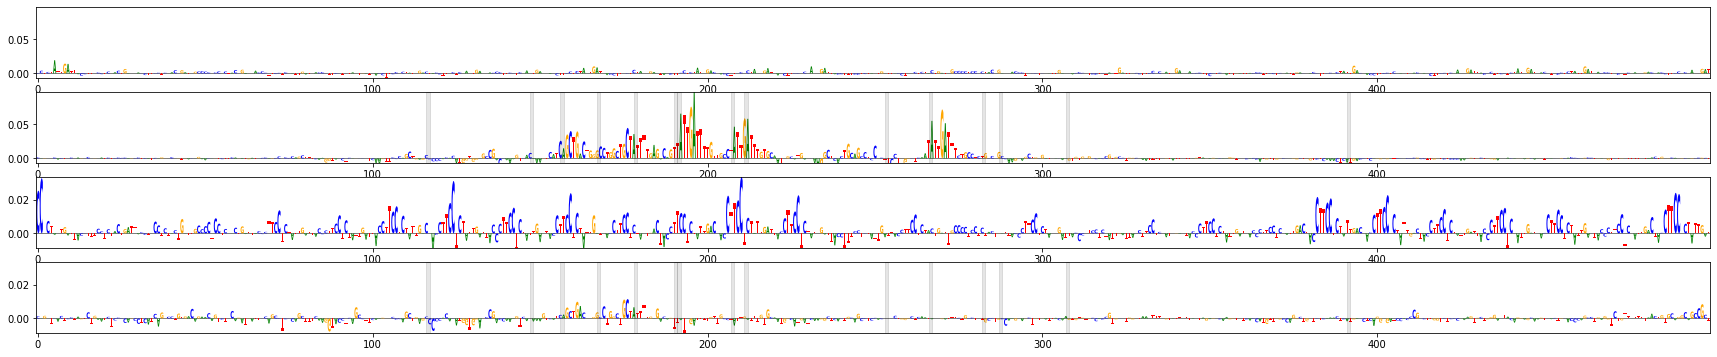

In [270]:
WINDOW = 500
SLICE_START = INP_LEN//2 - WINDOW//2
SLICE_END = INP_LEN//2 + WINDOW//2

fig, ax = plt.subplots(4, figsize=(30,6))

# ref_avg_prof = np.array([get_profile(ref_preds['allRetina'][CTYPE1][i])[EXAMPLE_IDX] for i in range(FOLDS)]).mean(0)
# alt_avg_prof = np.array([get_profile(alt_preds['allRetina'][CTYPE][i])[EXAMPLE_IDX] for i in range(FOLDS)]).mean(0)

# ax[0].plot(ref_avg_prof[max(0,(OUT_LEN-WINDOW))//2:(OUT_LEN+WINDOW)//2], 
#            label='ref ({})'.format(snp_lists['allRetina'].iloc[EXAMPLE_IDX]['ref']))
# ax[0].plot(alt_avg_prof[max(0, (OUT_LEN-WINDOW)//2):(OUT_LEN+WINDOW)//2], 
#            label='alt ({})'.format(snp_lists['allRetina'].iloc[EXAMPLE_IDX]['alt']))
# ax[0].legend()

# ax[1].vlines(1056 - SLICE_START + 0.5, ymin, ymax+1, 'k', linestyle='dashed')
# ax[2].vlines(1056 - SLICE_START + 0.5, ymin, ymax+1, 'k', linestyle='dashed')

logomaker.Logo(pd.DataFrame(projected_shap_scores1[0][SLICE_START:SLICE_END], columns=['A','C','G','T']),
              ax=ax[0])
logomaker.Logo(pd.DataFrame(projected_shap_scores1[1][SLICE_START:SLICE_END], columns=['A','C','G','T']),
              ax=ax[1])
logomaker.Logo(pd.DataFrame(projected_shap_scores2[0][SLICE_START:SLICE_END], columns=['A','C','G','T']),
              ax=ax[2])
logomaker.Logo(pd.DataFrame(projected_shap_scores2[1][SLICE_START:SLICE_END], columns=['A','C','G','T']),
              ax=ax[3])

l1,u1 = ax[0].get_ylim()
l2,u2 = ax[1].get_ylim()
ml1 = max(l1,l2)
mu1 = max(u1,u2)
ax[0].set_ylim((ml1,mu1))
ax[1].set_ylim((ml1,mu1))

l3,u3 = ax[2].get_ylim()
l4,u4 = ax[3].get_ylim()
ml2 = max(l3,l4)
mu2 = max(u3,u4)
ax[2].set_ylim((ml2,mu2))
ax[3].set_ylim((ml2,mu2))

for i in range(len(beam[0][1])):
    ax[1].add_patch(Rectangle((beam[0][1][i]-SLICE_START,ml1), 1, mu1-ml1, color="k", alpha=0.1))
    ax[3].add_patch(Rectangle((beam[0][1][i]-SLICE_START,ml2), 1, mu2-ml2, color="k", alpha=0.1))

# ax[1].set_ylim(ymin, ymax)
# ax[2].set_ylim(ymin, ymax)

# fig.suptitle("{} ({})".format(CTYPE, snp_lists['allRetina'].iloc[EXAMPLE_IDX]['rs']))
plt.show()